In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from scipy.stats import entropy

In [8]:
def load_data():
    mnist = fetch_openml('mnist_784', version=1 , parser='auto')
    X, y = mnist["data"], mnist["target"].astype(np.int8)
    return X, y

In [9]:
# Split data into initial training set, unlabeled pool, and test set
def split_data(X, y):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=50, stratify=y, random_state=42)
    X_unlabeled, X_test, y_unlabeled, y_test = train_test_split(X_temp, y_temp, train_size=0.5, stratify=y_temp, random_state=42)
    return X_train, y_train, X_unlabeled, y_unlabeled, X_test, y_test

In [10]:
# Train a model
def train_model(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    return accuracy, f1

In [11]:
# Random Sampling
def random_sampling(unlabeled_pool, n_samples):
    return np.random.choice(len(unlabeled_pool), n_samples, replace=False)

# Uncertainty Sampling: Least Confident
def least_confident(model, X_unlabeled, n_samples):
    probs = model.predict_proba(X_unlabeled)
    uncertainty = 1 - np.max(probs, axis=1)
    query_indices = np.argsort(uncertainty)[-n_samples:]
    return query_indices

# Uncertainty Sampling: Margin Sampling
def margin_sampling(model, X_unlabeled, n_samples):
    probs = model.predict_proba(X_unlabeled)
    margins = np.partition(probs, -2, axis=1)[:, -1] - np.partition(probs, -2, axis=1)[:, -2]
    query_indices = np.argsort(margins)[:n_samples]
    return query_indices

# Uncertainty Sampling: Entropy
def entropy_sampling(model, X_unlabeled, n_samples):
    probs = model.predict_proba(X_unlabeled)
    uncertainties = entropy(probs.T)
    query_indices = np.argsort(uncertainties)[-n_samples:]
    return query_indices

# Query by Committee
def query_by_committee(models, X_unlabeled, n_samples):
    votes = np.zeros((len(X_unlabeled), len(models)))
    for i, model in enumerate(models):
        votes[:, i] = model.predict(X_unlabeled)
    disagreement = np.array([len(set(v)) for v in votes])
    query_indices = np.argsort(disagreement)[-n_samples:]
    return query_indices


In [12]:
# Active Learning Loop
def active_learning(X_train, y_train, X_unlabeled, y_unlabeled, X_test, y_test, n_iterations, strategy):
    performance = []

    # Convert to numpy arrays if they are pandas DataFrames
    if hasattr(X_train, 'values'):
        train = train.values
    if hasattr(y_unlabeled, 'values'):
        y_unlabeled = y_unlabeled.values

    for i in range(n_iterations):
        model = train_model(X_train, y_train)
        accuracy, f1 = evaluate_model(model, X_test, y_test)
        performance.append((accuracy, f1))
        
        if strategy == 'random':
            query_indices = random_sampling(X_unlabeled, n_samples=10)
        elif strategy == 'least_confident':
            query_indices = least_confident(model, X_unlabeled, n_samples=10)
        elif strategy == 'margin_sampling':
            query_indices = margin_sampling(model, X_unlabeled, n_samples=10)
        elif strategy == 'entropy':
            query_indices = entropy_sampling(model, X_unlabeled, n_samples=10)
        elif strategy == 'qbc':
            committee_models = [train_model(X_train, y_train) for _ in range(3)]
            query_indices = query_by_committee(committee_models, X_unlabeled, n_samples=10)
        
        X_train = np.concatenate((X_train, X_unlabeled[query_indices]))
        y_train = np.concatenate((y_train, y_unlabeled[query_indices]))
        X_unlabeled = np.delete(X_unlabeled, query_indices, axis=0)
        y_unlabeled = np.delete(y_unlabeled, query_indices)
    
    return performance

# Visualization
def plot_performance(performance, strategy):
    performance = np.array(performance)
    iterations = np.arange(len(performance))
    plt.plot(iterations, performance[:, 0], label='Accuracy')
    plt.plot(iterations, performance[:, 1], label='F1 Score')
    plt.xlabel('Iteration')
    plt.ylabel('Performance')
    plt.title(f'Active Learning Performance ({strategy})')
    plt.legend()
    plt.show()


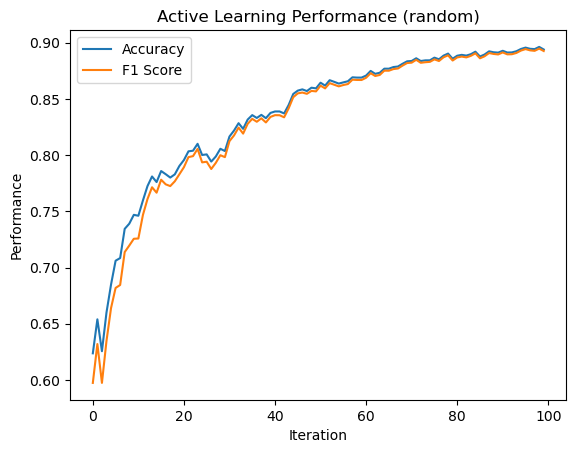

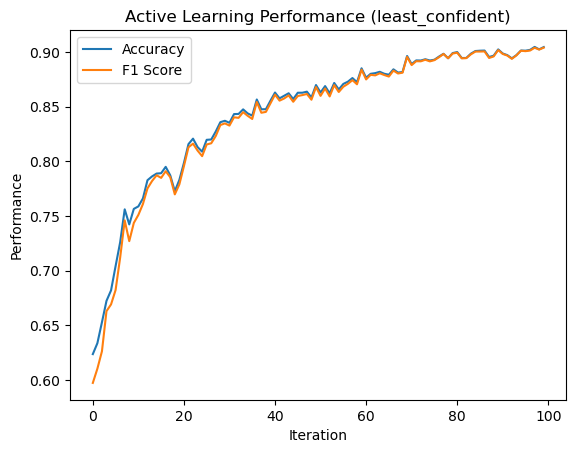

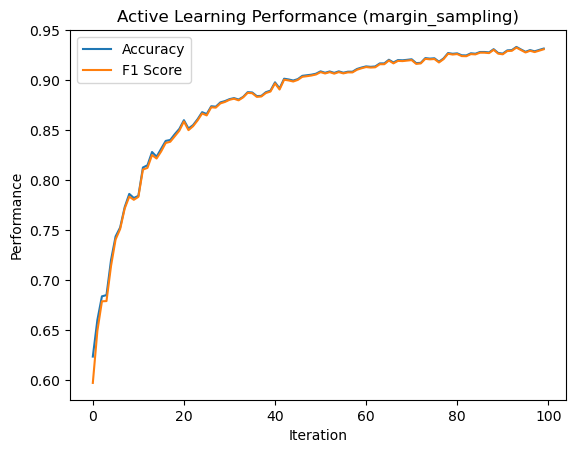

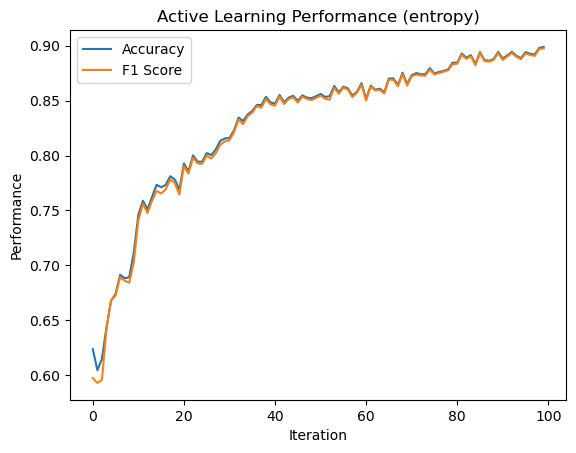

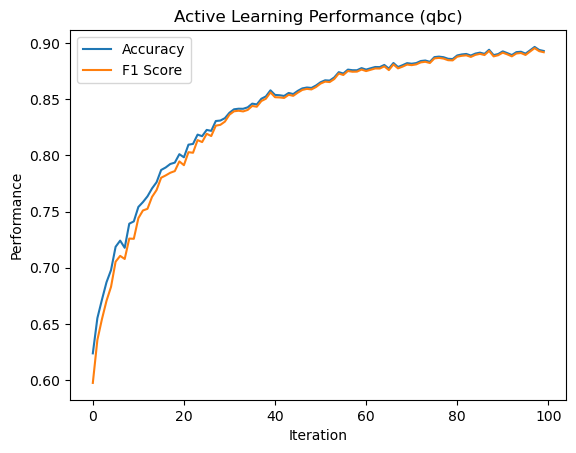

In [14]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
if __name__ == '__main__':
    X, y = load_data()
    X_train, y_train, X_unlabeled, y_unlabeled, X_test, y_test = split_data(X, y)
    
    n_iterations = 100
    strategies = ['random', 'least_confident', 'margin_sampling', 'entropy', 'qbc']
    
    for strategy in strategies:
        performance = active_learning(X_train, y_train, X_unlabeled, y_unlabeled, X_test, y_test, n_iterations, strategy)
        plot_performance(performance, strategy)
